## Mini Project 1: Least Squares Based Supervised Classification

#### Background

The below splits the contents of `mnist.mat` into 60,000 training image/label pairs, and 10,000 testing image/label pairs.

In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

In [2]:
mat_contents = scipy.io.loadmat('mnist', appendmat=True)
trainImages = mat_contents['trainX'] # trainImages.shape returns (60000, 784)
trainLabels = mat_contents['trainY'] # trainLabels.shape returns (1, 60000)
testImages = mat_contents['testX']   # testLabels.shape returns (10000, 784)
testLabels = mat_contents['testY']   # testLabels.shape returns (1, 10000)

Defining a function to help plot confusion matrices:

In [3]:
"""
Plot a confusion matrix using Matplotlib.

Parameters:
- conf_matrix: 2D numpy array, the confusion matrix
- classes: List of class names
- title: Title of the plot (default is 'Confusion Matrix')
- cmap: Colormap for the plot (default is plt.cm.Blues)
- return: Confusion matrix
"""
def plot_confusion_matrix(conf_matrix, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    fmt = 'd'
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], fmt),
                     ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

Visualizing ten random handwritten digits using `matplotlib`:

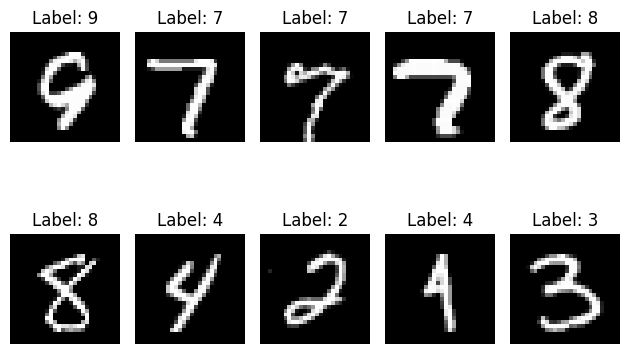

In [4]:
# Reshape the images from (60000, 784) to (60000, 28, 28)
displayImages = trainImages.reshape(60000, 28, 28)

# Transpose the labels to (60000,)
displayLabels = trainLabels.squeeze()

# Visualize 10 random images and labels
for i in range(10):
    rand = random.randint(0,59991)
    plt.subplot(2, 5, i + 1)
    plt.imshow(displayImages[rand], cmap='gray')
    plt.title(f"Label: {displayLabels[rand]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Problem 1: Least Squares Classifier

##### Task 1
Write your own code to implement the (i) one-versus-one and (ii) one-versus-all multi-class classifier using the binary classifier as building blocks. Your code should take appropriately labeled training data as the input, and determine the weights of the constituent binary classifiers as the output.

##### Binary classifier building block
Given $N$ data points $\left\{ (\mathbf{\vec{x}_1}, y_1), \ldots, (\mathbf{\vec{x}_N}, y_N) \right\}$
 where $x_i$ denotes the $i^{th}$ feature vector and $y_i \in \left\{ -1, 1 \right\}$ is the corresponding label for each data point. Given $N$ training data points, we try to find the best linear regression model by solving the following least squares problem:
$$ \operatorname{min}_{\beta, \alpha} \sum_{i = 1}^N \left( y_i - \mathbf{\beta^T \vec{x}_i} - \alpha \right)^2$$

Finding the best linear regression model cannot be found by simply solving $\mathbf{A\vec{x}}= \mathbf{\vec{y}}$, where

$$ 
\mathbf{A} = \begin{bmatrix}
x^{(1)}_1 & x^{(1)}_2 & \cdots & x^{(1)}_n & 1 \\
x^{(2)}_1 & x^{(2)}_2 & \cdots & x^{(2)}_n & 1 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
x^{(L)}_1 & x^{(L)}_2 & \cdots & x^{(L)}_n & 1 \\
\end{bmatrix},
\mathbf{\vec{x}} = \begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_n \\
\alpha
\end{bmatrix},
\mathbf{\vec{y}} = \begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_k
\end{bmatrix}
$$

and $L$ is the number of samples of $\mathbf{\vec{x}}$ and $n$ is the size of the feature vectors. This is because we are not guaranteed that $\mathbf{\vec{x}} \in \mathcal{R}(\mathbf{A})$. Finding the least squares solution $\mathbf{\vec{x}^*}$ where $\mathbf{A\vec{x}^*}$ is as close to $\mathbf{\vec{y}}$ as possible is equivalent to minimizing the length between $\mathbf{\vec{y}}$ and $\mathbf{A\vec{x}^*}$ as defined above. From lecture, the notion of length we want to minimize is the $\ell_2$ norm as defined as:

$$|| \mathbf{\vec{y}} - \mathbf{A\vec{x}^*}||_2^2 = \left( \sqrt{\sum_{i = 1}^N \left( y_i - \mathbf{\beta^T \vec{x}_i} - \alpha \right)^2} \right)^2 = \sum_{i = 1}^N \left( y_i - \mathbf{\beta^T \vec{x}_i} - \alpha \right)^2$$

From lecture, we know the closest vector $\mathbf{A\vec{x}^*}$ (i.e. our best approximation) is the projection of the vector $\mathbf{\vec{y}}$ onto $\mathcal{R}(\mathbf{A})$ (or the minimum $\ell_2$ norm). This means that the vector from $\mathbf{A\vec{x}^*}$ to $\mathbf{\vec{y}}$ is orthogonal to $\mathcal{R}(\mathbf{A})$. Expressing this vector as $\mathbf{A\vec{x}^*} - \mathbf{\vec{y}}$, we can write:

$$\mathbf{A^T}(\mathbf{A\vec{x}^*} - \mathbf{\vec{y}}) = \mathbf{\vec{0}}$$

Here, $\mathbf{A\vec{x}^*} - \mathbf{\vec{y}} \in \mathcal{N}(\mathbf{A^T})$. Now to rewrite this in terms of $\mathbf{\vec{x}^*}$, we can perform the following operations:

$$ \begin{aligned}
\mathbf{A^T}(\mathbf{A\vec{x}^*} - \mathbf{\vec{y}}) &= \mathbf{\vec{0}} \\
\mathbf{A^T A\vec{x}^*} - \mathbf{A^T \vec{y}} &= \mathbf{\vec{0}} \\
\mathbf{A^T A\vec{x}^*} &= \mathbf{A^T \vec{y}} \\
\mathbf{\vec{x}}^* &= \mathbf{\left( A^T A \right)^{-1} A^T \vec{y}} \\
\end{aligned} $$

Rewriting $\mathbf{\left( A^T A \right)^{-1} A^T}$ as $A^{+}$, we have:

$$
\mathbf{\vec{x}}^* = A^{+} \mathbf{\vec{y}}
$$

where $A^{+}$ is known as the [Moore-Penrose inverse](https://en.wikipedia.org/wiki/Moore–Penrose_inverse).

Now, let us obtain the Moore-Penrose inverse by using `np.linalg.pinv()`. In the below function definition, we preprocess the dataset such that we have the appropriate behavior in our implementation of the binary classifier. This includes adding an extra column of ones to our matrix $A$ to account for an intercept term

$\mathbf{A}$ by appending an intercept term to our dataset such that `trainImages.shape` returns `(60000, 785)`.

In [5]:
"""
Train a binary classifier using 60,000 samples from the MNIST 
dataset on a specified number.

Parameters:
- number: The specified number to train the binary classifier on.
- return: The solution to the least squares problem.
"""
def binary_classifier(train_x, train_y, number):
    A = np.column_stack((train_x, np.ones(len(train_x))))
    Y = train_y.astype('int8')
    
    for i in range(Y.shape[1]):
        if (Y[0, i] != number):
            Y[0, i] = -1
        else:
            Y[0, i] = 1

    psuedo_inverse = np.linalg.pinv(A)
    
    return np.dot(psuedo_inverse, Y.T)

In [22]:
"""
Evaluate a binary classifier on a specified number.

Parameters:
- test_x: The matrix of the testing dataset.
- test_y: The matrix of the testing labels.
- number: The specified number to test the binary classifier on.
- return: A confusion matrix and accuracies.
"""
def eval_binary_classifier(test_x, test_y, weights, number):
    test_A = np.column_stack((test_x, np.ones(len(test_x))))
    result = np.dot(test_A, weights)
            
    true_number_count = 0
    pred_number_count = 0
    fp = 0
    fn = 0
    tp = 0
    tn = 0

    for i in range(10000):
        # Count the number of correct positives
        if (result[i] >= 0) and (test_y[0][i] == number):
            tp += 1

        # Count the number of correct negatives
        if (result[i] < 0) and (test_y[0][i] != number):
            tn += 1

        # Count the number of false positives
        if (result[i] >= 0) and (test_y[0][i] != number):
            fp += 1

        # Count the number of false negatives
        if (result[i] < 0) and (test_y[0][i] == number):
            fn += 1

    conf_matrix = np.array([[tp, fn],
                            [fp, tn]])

    class_names = [f'{number}', f'Not {number}']

    plot_confusion_matrix(conf_matrix, class_names)

    

In [25]:
normalized_x = np.array(mat_contents['trainX']) / 255.0
normalized_y = np.array(mat_contents['trainY'])
weights_0 = binary_classifier(normalized_x, normalized_y , 3)

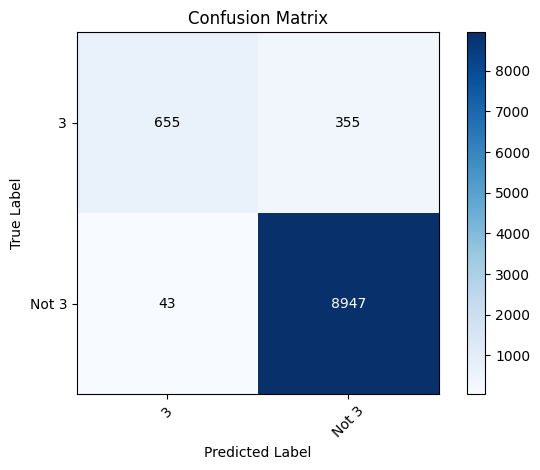

In [26]:
normalized_test_x = np.array(mat_contents['testX']) / 255.0
normalized_test_y = np.array(mat_contents['testY'])
eval_binary_classifier(normalized_test_x, normalized_test_y, weights_0, 3)

Let $\mathbf{\beta^*}, \alpha^*$ be the solution to the above problem. Then the **binary least squares classifier** $\mathbf{\hat{f}(x)}$ is given by
$$ \hat{f}(\mathbf{x}) = \operatorname{sign}(\mathbf{{\beta^*}^T x} + \alpha^*)$$
for arbitrary test data **x**. Here $\operatorname{sign}(a) = 1$ for $a \geq 0$ and $-1$ for $a < 0$.

Now, we can take the sign of each entry of $y$ to the binary classifier.

##### Task 2
Evaluate the training error of both classifiers using error rate and confusion matrix:
- The error rate is the total number of errors in predicted label divided by the total number of inputs being classified.
- Confusion matrix (ref. Pg. 287 and 298 from textbook)

##### Task 3
Evaluate the performance of both multi-class classifiers on the test data. Comment on their performance. How well do they generalize on the test data? Which digits are easy to recognize, which ones are harder?

#### Problem 2: Randomized Feature Based Least Square Classifiers

##### Task 1
Modify the code for Problem 1 to learn the multi-class classifier in the feature space. Use the following non-linear mappings to construct your feature vectors:
- **Identity Function:** $ g(x) = x $
- **Sigmoid Function:** $ g(x) = \frac{1}{1 + e^{-x}} $
- **Sinusoidal Function:** $ g(x) = \operatorname{sin}(x) $
- **Rectified Linear Unit (ReLU) Function:** $ g(x) = max(x,0) $
 
Assume that $L = 1000$ for this part. Compare the classification performance for different choices of the feature mapping by changing the non-linearity. Do these feature mappings perform better than the classifier learnt in Problem 2 on (i) Training data (ii) Testing data? Which feature mapping generalizes well, i.e., continues to perform well on the testing data? Discuss your results.

##### Task 2
Vary the number of features $L$, and plot the error rate as a function of the number of features $L$. Comment on how adding more features affects your classifier design.